In [1]:

from util import load_xyidst_threaded
from Transformer import get_freq_band
import numpy as np
from skimage.measure import block_reduce
import mne_features as mne_f

In [104]:
"""
    Parameters
"""
from tqdm import tqdm
source_folder_old = "data/greaterthan7/dataset/preprocessed/"
source_folder_young = "data/lessthan7/dataset/preprocessed/"
source_folder_all = "data/all/dataset/preprocessed/"

delta_low = 0.5
delta_high = 2
theta_low = 2
theta_high = 6
alpha_low = 6
alpha_high = 9
fs = 500.0

age = "old"

n_ch = 1
n_t = 1

"""
    Helper function
"""
def normalize(x):
    x_2d = np.reshape(x, (-1, x.shape[2]))
    xnorm_2d = (x_2d - np.nanmean(x_2d, axis=0)) / np.nanstd(x_2d, axis=0)
    return np.reshape(xnorm_2d, x.shape)

def get_features(x):
    x_f = []
    freqs = [[2,6],[6,9],[2,9]]
    n_ch=x.shape[1]

    for i in tqdm(range(x.shape[0])):
        mean = mne_f.univariate.compute_mean(x[i])
        std = mne_f.univariate.compute_std(x[i])
        ptp_amp = mne_f.univariate.compute_ptp_amp(x[i])
        #pow_freq_bands = mne_f.univariate.compute_pow_freq_bands(fs, x[i], np.array(freqs), ratios="only", ratios_triu=True, log=True)
        #print(pow_freq_bands.shape)
        #pow_freq_bands = np.reshape(pow_freq_bands, (n_ch, -1))
        #app_entropy = mne_f.univariate.compute_app_entropy(x[i])
        #plv = mne_f.bivariate.compute_phase_lock_val(x[i])

        feat = [mean, std, ptp_amp]
        #feat = feat + [pow_freq_bands[:,j] for j in range(pow_freq_bands.shape[1])]

        feat = np.array(feat).reshape(-1)

        x_f.append(feat)

    return np.array(x_f)

if age == "young":
    source_folder = source_folder_young
elif age == "old":
    source_folder = source_folder_old
elif age == "combined":
    source_folder = source_folder_all

phase = "train/"
x, y, ids, erp_t, speed, bad_chs = load_xyidst_threaded(
    source_folder + phase, verbose=False, load_bad_ch=True
)

x_train_raw = get_features(x)
y_train_raw = y
ids_train_raw = ids
t_train_raw = erp_t
speed_train_raw = speed
bad_chs_train = bad_chs
erp_t_train = erp_t

phase = "val/"
x, y, ids, erp_t, speed, bad_chs = load_xyidst_threaded(
    source_folder + phase, verbose=False, load_bad_ch=True
)

x_val_raw = get_features(x)
y_val_raw = y
ids_val_raw = ids
t_val_raw = erp_t
speed_val_raw = speed
bad_chs_val = bad_chs
erp_t_val = erp_t

phase = "test/"
x, y, ids, erp_t, speed, bad_chs = load_xyidst_threaded(
    source_folder + phase, verbose=False, load_bad_ch=True
)

x_test_raw = get_features(x)
y_test_raw = y
ids_test_raw = ids
t_test_raw = erp_t
speed_test_raw = speed
bad_chs_test = bad_chs
erp_t_test = erp_t

print(x_train_raw.shape)

100%|██████████| 257/257 [00:00<00:00, 1836.74it/s]

(489, 384)


In [112]:
"""
    Select speed(s)
"""

def filter_dataset(x, y, t, speed, ids, filt_arr, accepted_values):
    mask = np.zeros(filt_arr.shape, dtype=bool)
    for val in accepted_values:
        mask = np.logical_or(mask, filt_arr == val)
    
    return x[mask], y[mask], t[mask], speed[mask], ids[mask]

ACCEPTED_VALS = [2,3,4]

x_train_tmp, y_train, t_train, speed_train, ids_train = filter_dataset(x_train_raw, y_train_raw, t_train_raw, speed_train_raw, ids_train_raw, speed_train_raw, ACCEPTED_VALS)
x_val_tmp, y_val, t_val, speed_val, ids_val = filter_dataset(x_val_raw, y_val_raw, t_val_raw, speed_val_raw, ids_val_raw, speed_val_raw, ACCEPTED_VALS)
x_test_tmp, y_test, t_test, speed_test, ids_test = filter_dataset(x_test_raw, y_test_raw, t_test_raw, speed_test_raw, ids_test_raw, speed_test_raw, ACCEPTED_VALS)

In [97]:
ch = np.array([i for i in range(128)])
#ch = np.array([66, 67, 71, 72, 73, 76, 77, 78, 84, 85]) - 1

x_train = np.reshape(x_train_tmp[:,:,ch], (x_train_tmp.shape[0], -1))
x_val = np.reshape(x_val_tmp[:,:,ch], (x_val_tmp.shape[0], -1))
x_test = np.reshape(x_test_tmp[:,:,ch], (x_test_tmp.shape[0], -1))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [113]:
x_train = x_train_tmp
x_val = x_val_tmp
x_test = x_test_tmp

In [114]:
print(x_train.shape)
print(x_train[0,0])

(489, 384)
1.0446212827573687


In [115]:
from sklearn.svm import SVC
print(x_train[0,0].shape)
svc = SVC().fit(x_train, y_train)

()


In [116]:
y_pred_train = svc.predict(x_train)
y_pred_val = svc.predict(x_val)

In [117]:
acc = np.sum(y_pred_val == y_val) / y_pred_val.shape[0]
print(f"Accuracy (validation set): {np.round(acc*100, 1)}")

Accuracy (validation set): 58.5


In [111]:
acc = np.sum(y_pred_train == y_train) / y_pred_train.shape[0]
print(f"Accuracy (training set): {np.round(acc*100, 1)}")

Accuracy (training set): 57.8


In [45]:
from Transformer import TransformerExpandedEmanuel

transformer = TransformerExpandedEmanuel()

x_f_train = transformer.fit_transform(x_train, y_train, erp_t_train, bad_chs_train)
x_f_val = transformer.transform(x_val, bad_chs_val)
x_f_test = transformer.transform(x_test, bad_chs_test)


x_oz shape: (1458, 750)
x_erp shape: (1458, 250)
x_ref shape: (1458, 750)
x_oz shape: (1458, 750)
x_erp shape: (1458, 250)
x_ref shape: (1458, 750)
x_oz shape: (132, 750)
x_erp shape: (132, 250)
x_ref shape: (132, 750)
x_oz shape: (52, 750)
x_erp shape: (52, 250)
x_ref shape: (52, 750)


In [46]:
print(x_f_train.shape)
f_names = transformer.f_names

(1458, 68)


In [47]:
corr = np.corrcoef(x_f_train, rowvar=False)
print(corr.shape)

(68, 68)


In [48]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(x_f_train, y_train)
print(np.sum(mi))

0.9903844305100062


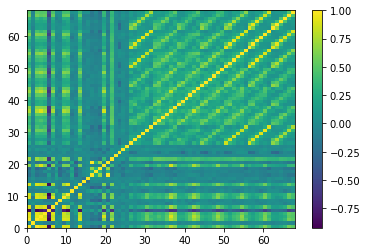

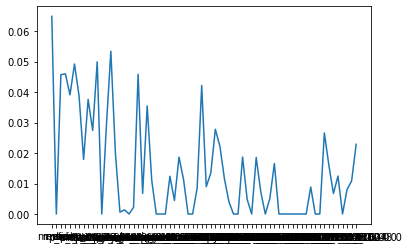

In [49]:
plt.figure()
plt.pcolormesh(corr)
plt.colorbar()

plt.figure()
plt.plot(f_names, mi)

In [50]:
good = mi > 0.001
f_names_adj = f_names[good]
x_f_train_adj = x_f_train[:,good]

print(f_names_adj)

print(x_f_train_adj.shape)


['rms' 'std' 'var' 'maximum' 'minimum' 'p_amplitude' 'p_latency' 'p_dur'
 'p_prom' 'n_amplitude' 'n_dur' 'n_prom' 'frac_area_latency'
 'zero_crossings' 'hjorth_mob' 'hjorth_act' 'petrosian_frac_dim'
 'bandpower' 'mean_phase_d' 'sxx_f0.0_t128.0' 'sxx_f0.0_t352.0'
 'sxx_f0.0_t576.0' 'sxx_f0.0_t800.0' 'sxx_f4.0_t128.0' 'sxx_f4.0_t352.0'
 'sxx_f4.0_t576.0' 'sxx_f4.0_t800.0' 'sxx_f4.0_t1024.0' 'sxx_f4.0_t1248.0'
 'sxx_f8.0_t128.0' 'sxx_f8.0_t352.0' 'sxx_f8.0_t1024.0' 'sxx_f8.0_t1248.0'
 'sxx_f12.0_t352.0' 'sxx_f12.0_t576.0' 'sxx_f12.0_t1024.0'
 'sxx_f12.0_t1248.0' 'sxx_f20.0_t352.0' 'sxx_f20.0_t1024.0'
 'sxx_f20.0_t1248.0' 'sxx_f23.0_t128.0' 'sxx_f23.0_t352.0'
 'sxx_f23.0_t800.0' 'sxx_f23.0_t1024.0' 'sxx_f23.0_t1248.0']
(1458, 45)


In [53]:
corr = np.corrcoef(x_f_train_adj, rowvar=False)
mi = mutual_info_classif(x_f_train_adj, y_train)
print(np.sum(mi))

0.9806777813266527


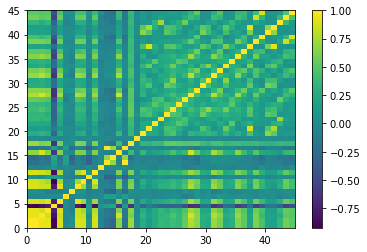

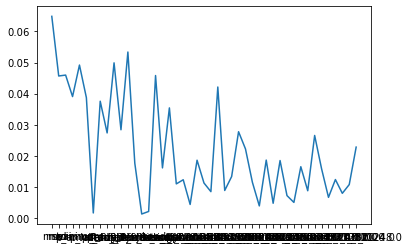

In [54]:
plt.figure()
plt.pcolormesh(corr)
plt.colorbar()

plt.figure()
plt.plot(f_names_adj, mi)

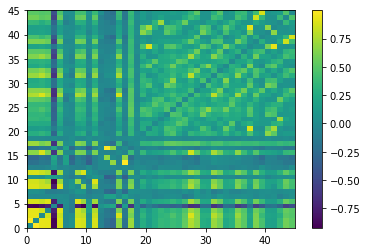

In [55]:
for i in range(corr.shape[0]):
    corr[i,i] = 0

thr = 0.9
plt.figure()
plt.pcolormesh(corr)
plt.colorbar()